In [ ]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings
import yfinance as yf

In [ ]:
pip install arch

In [ ]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 3,5

##Hurst exponent
Value near 0.5 indicates a random series.

Value near 0 indicates a mean reverting series.

Value near 1 indicates a trending series.

In [ ]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Creating the range of lag values
    lags = range(2, 100)

    # Calculating the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Using a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Returning the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [ ]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot time series
    x.plot(ax=axes[0][0])

    # Calculate and display statistics
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

    # Probability plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    # ACF plot with y-axis zoomed in
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    axes[1][0].set_xlabel('Lag')
    axes[1][0].set_ylim(-0.25, 0.25)  # Zoom in on the y-axis range

    # PACF plot with y-axis zoomed in
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][1].set_xlabel('Lag')
    axes[1][1].set_ylim(-0.25, 0.25)  # Zoom in on the y-axis range

    # Adjust layout for better visibility
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Display the plot
    plt.show()

In [ ]:
sp_data = yf.download('SPY', start='2005-01-01', end='2024-01-01')[['High','Low','Open','Close','Volume','Adj Close']]
sp_data.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4781 entries, 2005-01-03 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       4781 non-null   float64
 1   Low        4781 non-null   float64
 2   Open       4781 non-null   float64
 3   Close      4781 non-null   float64
 4   Volume     4781 non-null   int64  
 5   Adj Close  4781 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 261.5 KB


In [ ]:
sp_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-01-03,121.760002,119.900002,121.559998,120.300003,55748000,83.623352
2005-01-04,120.540001,118.440002,120.459999,118.830002,69167600,82.601532
2005-01-05,119.250000,118.000000,118.739998,118.010002,65667300,82.031548
2005-01-06,119.150002,118.260002,118.440002,118.610001,47814700,82.448608
2005-01-07,119.230003,118.129997,118.970001,118.440002,55847700,82.330467


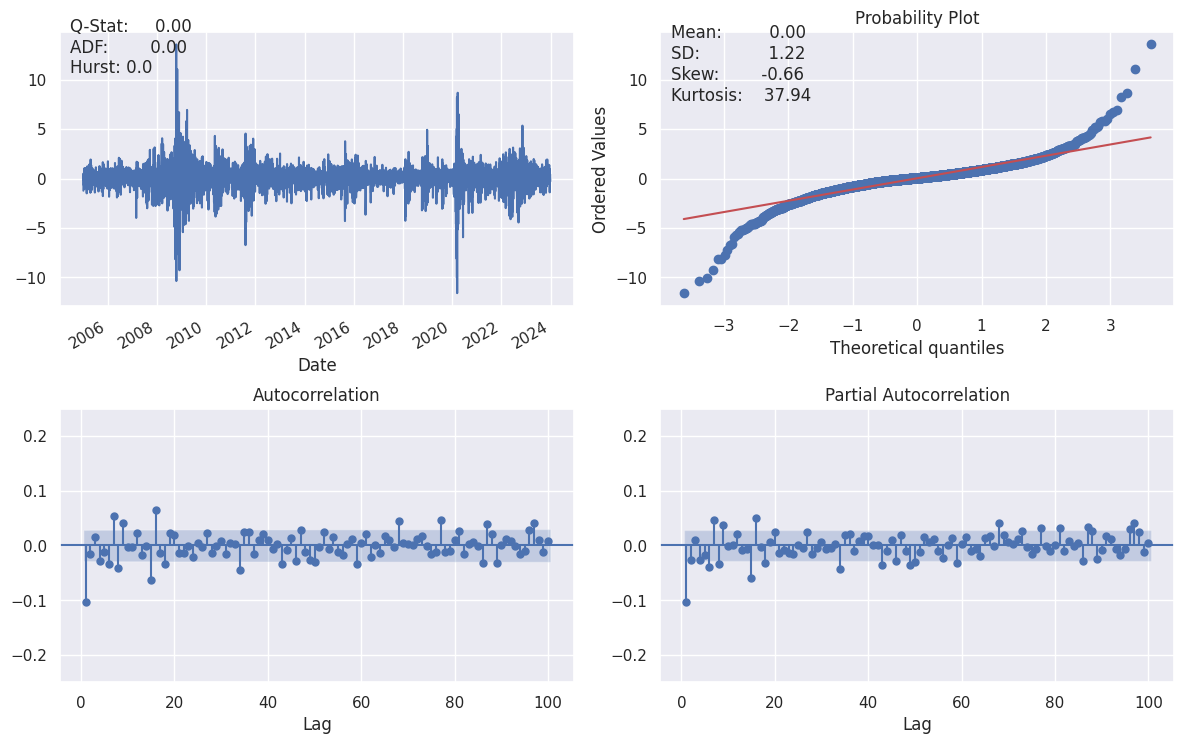

In [ ]:
# Calculate daily returns as percentage price changes
sp_data['Return'] = 100 * (sp_data['Close'].pct_change())
sp_data['Log_Return'] = np.log(sp_data['Close']).diff().mul(100) # rescale to faciliate optimization
sp_data = sp_data.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(sp_data['Log_Return'], lags=100, title='S&P 500 (Log, Diff)')

Q statistic is less than the critical value, it suggests that there is no significant autocorrelation in the residuals, indicating that the model adequately captures the autocorrelation structure of the data.

Hurst is 0 hence it is a mean reverting series

ACF and PACF very low (almost 0) -> Market efficient hypothesis?

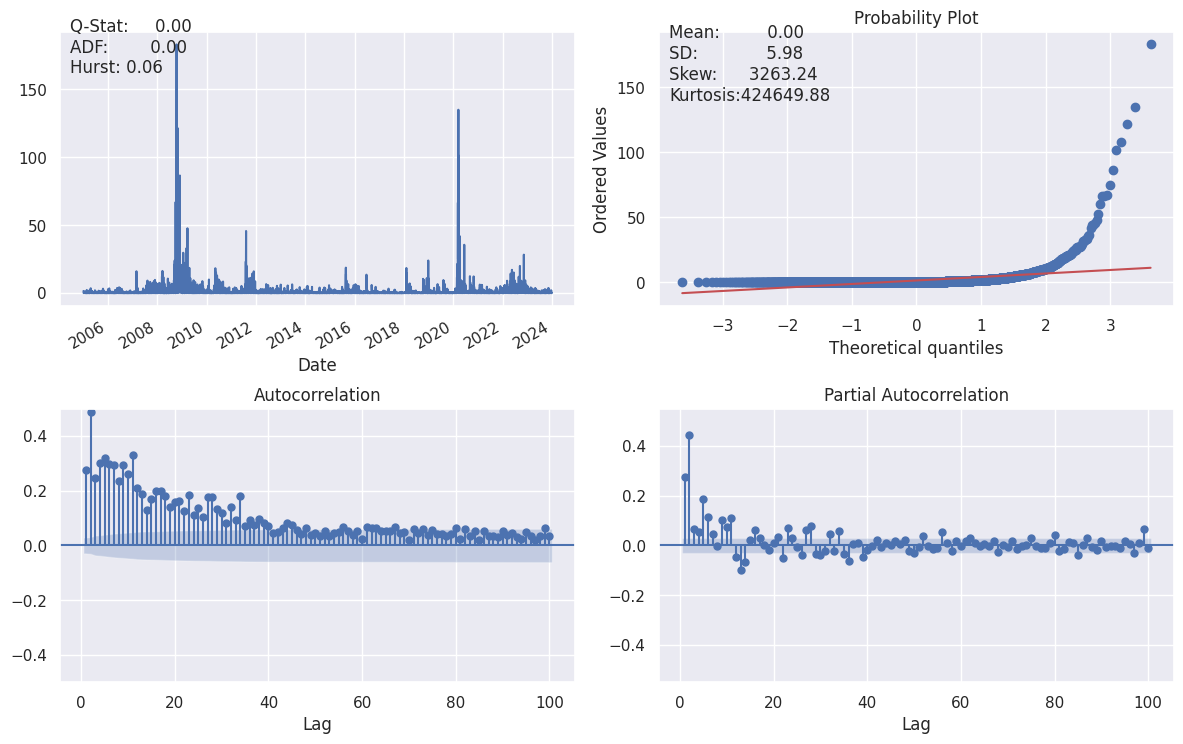

In [ ]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot time series
    x.plot(ax=axes[0][0])

    # Calculate and display statistics
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

    # Probability plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    # ACF plot with y-axis zoomed in
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    axes[1][0].set_xlabel('Lag')
    axes[1][0].set_ylim(-0.5, 0.5)  # Zoom in on the y-axis range

    # PACF plot with y-axis zoomed in
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][1].set_xlabel('Lag')
    axes[1][1].set_ylim(-0.55, 0.55)  # Zoom in on the y-axis range

    # Adjust layout for better visibility
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Display the plot
    plt.show()
plot_correlogram(sp_data['Log_Return'].sub(sp_data['Log_Return'].mean()).pow(2), lags=100, title='S&P 500 Daily Volatility')
# (log_return - log_return_mean)^2 -> a.k.a the residuals

In [ ]:
# Calculate daily std of returns
std_daily = sp_data['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 1.22%

Monthly volatility: 5.59%

Annual volatility: 19.36%


#ARCH and GARCH
##Model notations
Expected return:
μ=Expected|rt|I(t−1)

Expected volatility:
σ2=Expected[(rt−μt)2|I(t−1)]

Residual (prediction error):
rt=μ+ϵt

Volatility is related to the residuals:
ϵt=σt∗ζ(WhiteNoise)

##Model intuition

Autoregressive: predict future behavior based on past behavior.

Volatility as a weighted average of past information.

GARCH(1,1) parameter constraints

All parameters are non-negative, so the variance cannot be negative.
ω,α,β>=0

Model estimations are "mean-reverting" to the long-run variance.
α+β<1

long-run variance:
ω/(1−α−β)

GARCH(1,1) parameter dynamics

The larger the α , the bigger the immediate impact of the shock

The larger the β , the longer the duration of the impact

Given the GARCH(1,1) model equation as:

GARCH(1,1):σ^2(t)=ω+αϵ^(2)t−1+βσ^2(t−1)

ARCH(1) and GARCH(1,1) time series respectively using a function simulate_GARCH(n, omega, alpha, beta = 0).

Difference between an ARCH(1) and a GARCH(1,1) model is: besides an autoregressive component of α multiplying lag-1 residual squared, a GARCH model includes a moving average component of β multiplying lag-1 variance.

The function will simulate an ARCH/GARCH series based on n (number of simulations), omega, alpha, and beta (0 by default) you specify. It will return simulated residuals and variances.

In [ ]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)

    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]

    return resid, variance

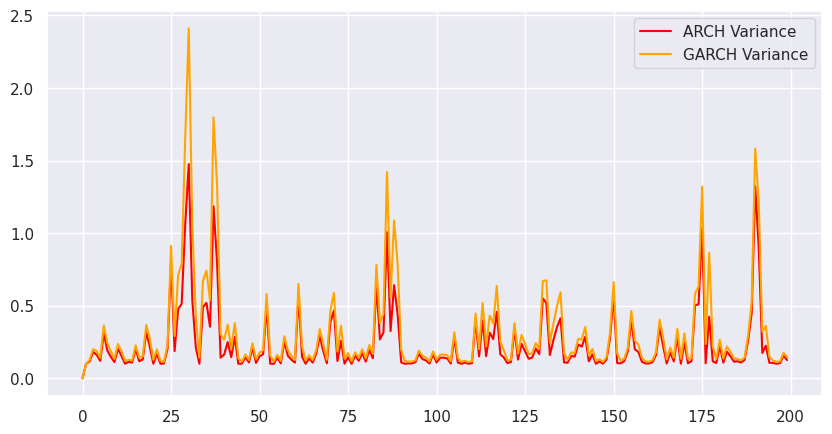

In [ ]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200,
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200,
                                             omega = 0.1, alpha = 0.7,
                                             beta = 0.1)

# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')

# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

The plot shows that the GARCH model has a higher variance than the ARCH model for most of the time period. This is because the GARCH model takes into account the fact that the volatility of a financial time series can be persistent, meaning that high volatility periods tend to be followed by other high volatility periods.



We will call the function simulate_GARCH() again, and study the impact of GARCH model parameters on simulated results.

Specifically, we will simulate two GARCH(1,1) time series, they have the same omega and alpha, but different beta as input.

In GARCH(1,1), since β is the coefficient of lag-1 variance, if the α is fixed, the larger the β, the longer the duration of the impact. In other words, high or low volatility periods tend to persist. Pay attention to the plotted results and see whether we can verify the β impact.

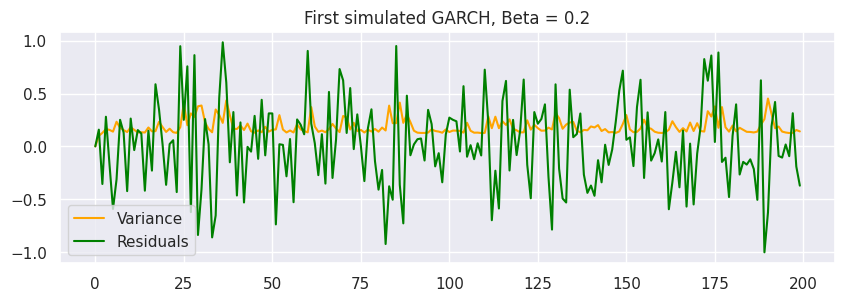

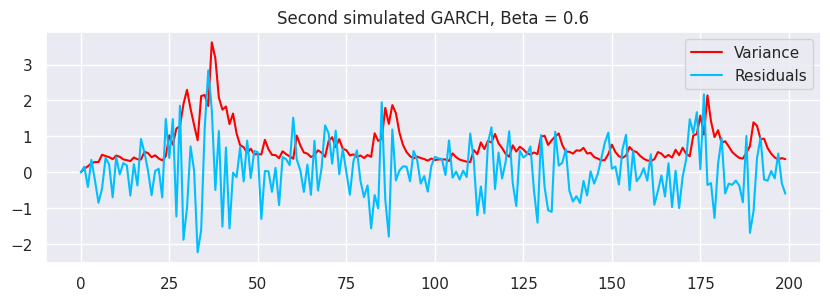

In [ ]:
# First simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GAxxxxxxxRCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

Fairly intuitive because more beta would mean more emphasis (weights) on the volatility and hence more value of future value of volatility.


Python arch package has a function arch_model() to implement a GARCH(1,1) model.

In [ ]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     29,   Neg. LLF: 6526.874199596803
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6374.970051847435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6374.969991040916
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11


In [ ]:
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6374.97
Distribution:                  Normal   AIC:                           12757.9
Method:            Maximum Likelihood   BIC:                           12783.8
                                        No. Observations:                 4780
Date:                Mon, Jan 22 2024   Df Residuals:                     4779
Time:                        16:34:51   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0720  1.119e-02      6.436  1.223e-10 [5.

<Figure size 2000x1500 with 0 Axes>

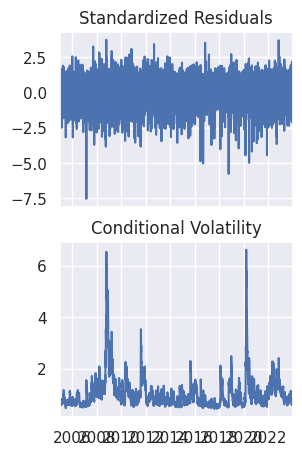

In [ ]:
plt.figure(figsize=(20,15))
gm_result.plot()
plt.show()

In [ ]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                h.1       h.2      h.3       h.4       h.5
Date                                                      
2023-12-29  0.44203  0.459815  0.47722  0.494253  0.510921


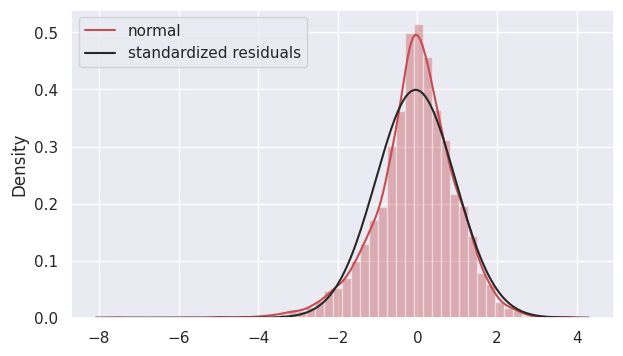

In [ ]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [ ]:
# Specify GARCH model assumptions
skewt_gm = arch_model(sp_data['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

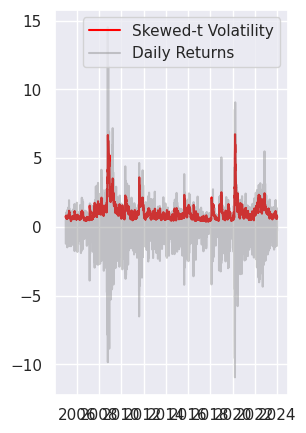

In [ ]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(sp_data['Return'], color = 'grey',
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()
